**Project 4** - Group 2 (Emma, Gabriel, Ben, Junhao)

<br>

<font size="6">Part 2: Modelling

## Load Libraries / Import Datasets

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from geopy.distance import geodesic

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.metrics import (
    confusion_matrix, 
    plot_confusion_matrix,
    accuracy_score,
    plot_roc_curve,
    roc_auc_score,
    recall_score,
    precision_score,
    f1_score
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from xgboost import XGBClassifier

pd.set_option('display.max_colwidth', 0)

In [25]:
train_weather = pd.read_csv(r'../datasets/train_weather_v3.csv')
test_weather = pd.read_csv(r'../datasets/test_weather_v3.csv')
submission = pd.read_csv(r'../datasets/sampleSubmission.csv')

The cleaned test dataset has ~13 times more entries than the train dataset.

In [26]:
train_weather.shape

(8475, 28)

In [27]:
test_weather.shape

(116293, 28)

## Functions

In [28]:
def get_model(model, gridcv, pipe_params={}):
    '''Function to apply GriSearchCV based on selected model and parameters'''
    
    #Scale X
    ss = StandardScaler()
    Xsc_train = ss.fit_transform(X_train)
    Xsc_test = ss.transform(X_test)
    
    #Models to test
    models = {'lr': LogisticRegression(),
              'nb': MultinomialNB(),
              'rf': RandomForestClassifier(),
              'et': ExtraTreesClassifier(),
              'ada': AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
              'knn': KNeighborsClassifier(),
              'gb': GradientBoostingClassifier(),
              'xgb': xgb.XGBClassifier()
             }
    
    #pipeline to include SMOTE since this is an unbalanced dataset 
    pipe = imbpipeline([
        ('sm', SMOTE(random_state=42)), 
        (model, models[model]),
            ])
    
    pipe_params = pipe_params
    
    #GriSesarchCV on user assigned parameters
    gridsearch = GridSearchCV(pipe, pipe_params, cv=gridcv, scoring='roc_auc', verbose=1, n_jobs=-1)
    
    gridsearch.fit(Xsc_train, y_train)
    
    #predict on test 
    preds = gridsearch.predict(Xsc_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    model_probs_train = gridsearch.predict_proba(Xsc_train)[:, 1]
    model_probs_test = gridsearch.predict_proba(Xsc_test)[:, 1]
    roc_auc = cross_val_score(pipe, Xsc_train, y_train, scoring='roc_auc', cv=gridcv)
    best_params = gridsearch.best_params_
    
    #Metrics to produce
    summary ={
        'model': model,
        'accuracy': accuracy_score(y_test, preds),
        'specificity': tn / (tn+fp),
        'recall': recall_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'f1_score': f1_score(y_test, preds),
        'AUC_CV': roc_auc.mean(),
        'AUC_train': roc_auc_score(y_train, model_probs_train),
        'AUC_test': roc_auc_score(y_test, model_probs_test),
        'best params': best_params}
    
    summary_df = pd.DataFrame.from_dict(summary, orient='Index', columns=[str(model)])

    return summary_df

## Modelling

In this section, we will train our dataset over 6 different models and evaluate them based on:
- ROC AUC score
- Recall and Precision (F1 score)

The ROC-AUC is the key metric here because it helps us to evaluate how well our models are performing when predicting the probability of a binary outcome (in this case, whether WNV is present or not).

We want to minimise false negatives (type II error). Therefore, evaluating our model on their recall score is also an important factor. Incorrectly predicting 'no occurrence of WNV' at an address could potentially result in serious, or even deadly, consequences when we miss out on controlling for the virus there. 

To a smaller extent, we are also interested in minimising false positives from a cost perspective. This is in view of our cost-benefit analysis in which we aim to minimise spraying costs by not targetting areas where it will be less effective. Precision score is something that we will look at as well, albeit with less importance than the ROC AUC and recall scores.

In [29]:
#Train/Test(aka Validation) split on Train dataset 

X = train_weather.drop(columns=['WnvPresent'])
y = train_weather['WnvPresent'] 
    
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

metrics = pd.DataFrame(index=[0])

### Baseline 

For the baseline model, we run it a logistic regression model with no parameter tuning. It produced a ROC_AUC test score of 0.81. 

*Note: We have encountered multiple convergence warning messages when running the logistic regression model. Despite adjusting max_iter, it has no effect on eliminating this error message. We have inspected our train/test scores, which look ok, and we have decided to proceed as such.*

In [30]:
get_model('lr', 5, pipe_params={})

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

,lr
model,lr
accuracy,0.73714
specificity,0.735661
recall,0.763158
precision,0.141005
f1_score,0.23803
AUC_CV,0.833047
AUC_train,0.844657
AUC_test,0.817988
best params,{}


### Logistic Regression

In [31]:
%%time

lr_results = get_model('lr', 5, pipe_params={
    'lr__C' : np.logspace(0.01, 1, 10),
    'lr__solver': ['sag','saga', 'liblinear'],    
    'lr__max_iter': [1000, 5000, 10000]
})

lr_results

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

CPU times: user 5.2 s, sys: 140 ms, total: 5.34 s
Wall time: 3min 49s


/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

,lr
model,lr
accuracy,0.73714
specificity,0.735661
recall,0.763158
precision,0.141005
f1_score,0.23803
AUC_CV,0.833047
AUC_train,0.844653
AUC_test,0.817984
best params,"{'lr__C': 1.023292992280754, 'lr__max_iter': 1000, 'lr__solver': 'saga'}"


### Random Forest

In [32]:
%%time

rf_results = get_model('rf', 5, pipe_params={
    'rf__n_estimators': [100, 150, 200],
    'rf__min_samples_split': [2, 3, 5],
    'rf__min_samples_leaf': [2, 5]
})

rf_results

Fitting 5 folds for each of 18 candidates, totalling 90 fits
CPU times: user 11.6 s, sys: 154 ms, total: 11.8 s
Wall time: 36 s


,rf
model,rf
accuracy,0.900425
specificity,0.931671
recall,0.350877
precision,0.225989
f1_score,0.274914
AUC_CV,0.749611
AUC_train,0.938776
AUC_test,0.817774
best params,"{'rf__min_samples_leaf': 5, 'rf__min_samples_split': 3, 'rf__n_estimators': 200}"


### K Nearest Neighbors

In [33]:
%%time

knn_results = get_model('knn', 5, pipe_params={
    'knn__leaf_size': [10, 20, 30],
    'knn__n_neighbors': [10, 25, 50, 75],
    'knn__p': [1, 2]
})

knn_results

Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: user 10.2 s, sys: 1.43 s, total: 11.6 s
Wall time: 17.9 s


,knn
model,knn
accuracy,0.746579
specificity,0.74813
recall,0.719298
precision,0.139693
f1_score,0.233951
AUC_CV,0.729757
AUC_train,0.904566
AUC_test,0.784709
best params,"{'knn__leaf_size': 10, 'knn__n_neighbors': 50, 'knn__p': 1}"


### GradientBoost

In [34]:
%%time

gb_results = get_model('gb', 5, pipe_params={
    'gb__max_depth': [3,5],
    'gb__n_estimators': [50, 100, 150],
    'gb__learning_rate': [.05, .1, .15],
    'gb__min_samples_leaf':[10,15],
    'gb__min_samples_split':[10, 15],
})

gb_results

Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: user 15.5 s, sys: 179 ms, total: 15.6 s
Wall time: 3min 15s


,gb
model,gb
accuracy,0.879188
specificity,0.901247
recall,0.491228
precision,0.220472
f1_score,0.304348
AUC_CV,0.837504
AUC_train,0.894464
AUC_test,0.828094
best params,"{'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__min_samples_leaf': 10, 'gb__min_samples_split': 10, 'gb__n_estimators': 150}"


### AdaBoost

In [35]:
%%time

ada_results = get_model('ada', 5, pipe_params={
    'sm__k_neighbors': [20, 50, 80], 
    'ada__n_estimators': [30, 50, 80],
    'ada__learning_rate': [0.1, 0.3, 0.7, 1],
    'ada__base_estimator__max_depth': [1, 2] 
})

ada_results

Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: user 13.7 s, sys: 178 ms, total: 13.9 s
Wall time: 1min 12s


,ada
model,ada
accuracy,0.934403
specificity,0.981047
recall,0.114035
precision,0.254902
f1_score,0.157576
AUC_CV,0.724283
AUC_train,0.893912
AUC_test,0.830113
best params,"{'ada__base_estimator__max_depth': 2, 'ada__learning_rate': 0.3, 'ada__n_estimators': 80, 'sm__k_neighbors': 50}"


### XGBoost

*Note: The team has investigated these warning messages when XGBoost is run. 1) we have set use_label_encoder = False to address the issue of the soon-to-be deprecated parameter. 2) the default evaluation metric warning for binary:logistic is just a warning to users on the recent change of the default error metric.*

In [36]:
%%time

xgb_results = get_model('xgb', 5, pipe_params={
    'xgb__use_label_encoder' : [False],
    'xgb__learning_rate' : [0.17, 0.1],
    'xgb__min_child_weight': [1, 3],
    'xgb__max_depth' : [1, 3],
    'xgb__n_estimators' : [50, 100],
    'xgb__gamma' : [0.05, 0.1],
    'xgb__subsample': [0.75, 1],
    'xgb__colsample_bytree': [0.75, 1],
    'xgb__objective': ['binary:logistic'],
    'xgb__eval_metric': ['auc'],
    'xgb__early_stopping_rounds': [10]
})

xgb_results

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[18:59:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 30.1 s, sys: 397 ms, total: 30.5 s
Wall time: 2min


,xgb
model,xgb
accuracy,0.877773
specificity,0.900249
recall,0.482456
precision,0.215686
f1_score,0.298103
AUC_CV,0.833137
AUC_train,0.896163
AUC_test,0.8291
best params,"{'xgb__colsample_bytree': 0.75, 'xgb__early_stopping_rounds': 10, 'xgb__eval_metric': 'auc', 'xgb__gamma': 0.05, 'xgb__learning_rate': 0.17, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 100, 'xgb__objective': 'binary:logistic', 'xgb__subsample': 0.75, 'xgb__use_label_encoder': False}"


## Summary

Overall, we chose the Gradient Boost model. 
- Even though the ADA Boost model provided the best AUC score, it performs poorly in terms of recall and has the lowest F1 score.
- On the other hand, the XGBoost and Gradient Boost model have the 2nd and 3rd best AUC score @ ~83%. 
- We are trying to reduce false negatives (we want to avoid predicting 'no WNV' incorrectly), hence choosing the XGBoost or Gradient Boost over ADA Boost was an obvious decision since it has a much higher recall score (49% vs 11%)
- We decided on the Gradient Boost model because it has a slightly better F1 score, and is faster to tune considering it has less hyperparameters for tuning.

In [37]:
overall_df = pd.concat([lr_results, rf_results, knn_results, gb_results, ada_results, xgb_results], axis=1).T
overall_df.sort_values(ascending=False, by='AUC_test').drop(columns=['model'])

,accuracy,specificity,recall,precision,f1_score,AUC_CV,AUC_train,AUC_test,best params
ada,0.934403,0.981047,0.114035,0.254902,0.157576,0.724283,0.893912,0.830113,"{'ada__base_estimator__max_depth': 2, 'ada__learning_rate': 0.3, 'ada__n_estimators': 80, 'sm__k_neighbors': 50}"
xgb,0.877773,0.900249,0.482456,0.215686,0.298103,0.833137,0.896163,0.8291,"{'xgb__colsample_bytree': 0.75, 'xgb__early_stopping_rounds': 10, 'xgb__eval_metric': 'auc', 'xgb__gamma': 0.05, 'xgb__learning_rate': 0.17, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 100, 'xgb__objective': 'binary:logistic', 'xgb__subsample': 0.75, 'xgb__use_label_encoder': False}"
gb,0.879188,0.901247,0.491228,0.220472,0.304348,0.837504,0.894464,0.828094,"{'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__min_samples_leaf': 10, 'gb__min_samples_split': 10, 'gb__n_estimators': 150}"
lr,0.73714,0.735661,0.763158,0.141005,0.23803,0.833047,0.844653,0.817984,"{'lr__C': 1.023292992280754, 'lr__max_iter': 1000, 'lr__solver': 'saga'}"
rf,0.900425,0.931671,0.350877,0.225989,0.274914,0.749611,0.938776,0.817774,"{'rf__min_samples_leaf': 5, 'rf__min_samples_split': 3, 'rf__n_estimators': 200}"
knn,0.746579,0.74813,0.719298,0.139693,0.233951,0.729757,0.904566,0.784709,"{'knn__leaf_size': 10, 'knn__n_neighbors': 50, 'knn__p': 1}"


In [38]:
ss = StandardScaler()
Xsc_train = ss.fit_transform(X_train)
Xsc_test = ss.transform(X_test)

pipe = imbpipeline([
                ('sm', SMOTE(random_state=42)), 
                ('gb', GradientBoostingClassifier()),
            ])

pipe_params = {
    'gb__learning_rate': [0.1], 
    'gb__max_depth': [3], 
    'gb__min_samples_leaf': [10], 
     'gb__min_samples_split': [15], 
     'gb__n_estimators': [150]
}
    
#GriSesarchCV on user assigned parameters
gb_gridsearch = GridSearchCV(pipe, pipe_params, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    
gb_gridsearch.fit(Xsc_train, y_train)

gb_preds = gb_gridsearch.predict(Xsc_test)
tn, fp, fn, tp = confusion_matrix(y_test, gb_preds).ravel()

gb_model_probs_train = gb_gridsearch.predict_proba(Xsc_train)[:, 1]
gb_model_probs_test = gb_gridsearch.predict_proba(Xsc_test)[:, 1]
gb_roc_auc = cross_val_score(pipe, Xsc_train, y_train, scoring='roc_auc', cv=5)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


### ROC-AUC curve

We plot an ROC-AUC curve which measures the model's performance at different thresholds.  The false positive rate located on the x-axis represents the proportion of samples that had no WMV that were incorrectly classified, while the true positive rate, located on the y-axis, represents the proportion of WMV samples that were correctly classified. 

The baseline (dotted orange line) shows that the false positive rate is equivalent to the true positive rate. The area under the curve (baseline) is equivalent to 0.5. 

The gradient boost model attained an AUC score of 0.83, higher than the baseline model and 3 other models mentioned above, validating its higher predictive ability to distinguish between classes. 

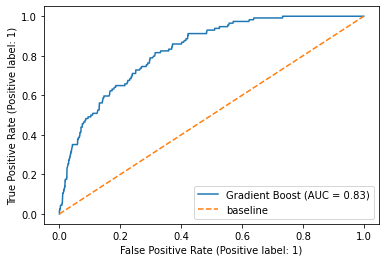

In [39]:
plot_roc_curve(gb_gridsearch, Xsc_test, y_test, name='Gradient Boost')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

### Confusion Matrix

Next, we plot a confusion matrix. 
The x-axis reflects the predicted class while the y-axis reflects the actual class. 

As can be seen below, the gradient boost model performs somewhat poorly on identifying the presence of WMV when WMV is present. There were 58 instances where WMV was incorrectly predicted to be absent.  In contrast, there were only 56 instances where WMV was correctly predicted to be present. This ties back to the poorer recall (0.491228) and precision scores (0.304348) observed above. Nevertheless, it should be noted that the chosen GB model scored better than at least 2 of the other models on these scores.  Reducing the number of false negatives and improving the true positives would lend the model a higher predictive ability.  Perhaps this could be done by training with more data (e.g. more data on spray besides the 10 day worth of spray data, data on WMV presence a day after spray etc) and other features that were not provided in the dataset.    

In contrast the model is able to predict 90% of the time that WMV is absent when it is absent. (1807 correctly predicted WMV absent cases out of 2005 WMV absent cases).  It incorrectly predicts 198 WMV absent cases.

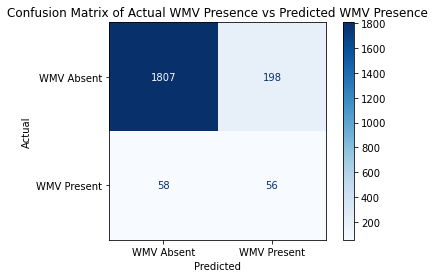

In [40]:
plot_confusion_matrix(gb_gridsearch, Xsc_test, y_test,cmap='Blues', 
                      values_format='d', 
                      display_labels=["WMV Absent", "WMV Present"])
plt.title("Confusion Matrix of Actual WMV Presence vs Predicted WMV Presence")
plt.xlabel('Predicted')
plt.ylabel('Actual');

### Feature Analysis

Feature importance indicates the relative importance of each feature when making a prediction. 

Feature importance scores for all features were relatively conservative (below 0.3). "August" (0.282), "Tavg" (0.102), "AvgSpeed" (0.076), species "Culex Restuans" (0.071) and "DewPoint" (0.064) had the highest feature importance. These results are not surprising. in the EDA notebook, features "Tavg"(0.08), "DewPoint"(0.069), "Culex Restuans"(-0.094) and "AvgSpeed"(-0.089) were observed to have higher absolute correlation with WMV. 

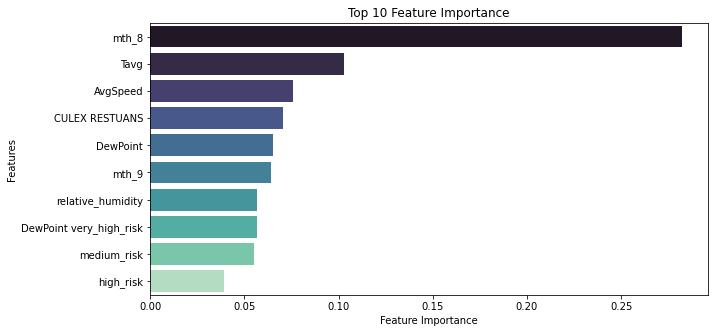

In [41]:
## Plot top 10 feature importance
feature_importance = pd.DataFrame(gb_gridsearch.best_estimator_.steps[1][1].feature_importances_, index = X_train.columns, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)

top_10 = feature_importance.head(10)
plt.figure(figsize=(10,5))
sns.barplot(y=top_10.index,x="Feature Importance", data=top_10, palette = 'mako')
plt.title('Top 10 Feature Importance')
plt.ylabel('Features');

## Kaggle Model

The model that we have decided to use is the Gradient Boost model and these are the parameters which we will use to run our predictions on for the Kaggle competition. We obtained a Kaggle score of nearly 70%.



In [42]:
#Import full train and test dataset

X_full_train = train_weather.drop(columns=['WnvPresent'])
X_full_test = test_weather.drop(columns=['Id'])
y_full_train = train_weather['WnvPresent']


In [43]:
ss = StandardScaler()
X_full_train_sc = ss.fit_transform(X_full_train)
X_full_test_sc = ss.transform(X_full_test)

pipe = imbpipeline([
                ('sm', SMOTE(random_state=42)), 
                ('gb', GradientBoostingClassifier()),
            ])

pipe_params = {
    'gb__learning_rate': [0.1], 
    'gb__max_depth': [3], 
    'gb__min_samples_leaf': [10], 
     'gb__min_samples_split': [15], 
     'gb__n_estimators': [150]
}
    
gridsearch = GridSearchCV(pipe, pipe_params, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    
gridsearch.fit(X_full_train_sc, y_full_train)
    
preds = gridsearch.predict_proba(X_full_test_sc)
best_params = gridsearch.best_params_

model_probs_train = gridsearch.predict_proba(X_full_train_sc)[:, 1]
model_probs_test = gridsearch.predict_proba(X_full_test_sc)[:, 1]
roc_auc = cross_val_score(pipe, X_full_train_sc, y_full_train, scoring='roc_auc', cv=5)

summary_final ={
        'model': 'Gradient Boost',
        'AUC_CV': roc_auc.mean(),
        'best params': best_params}


summary_final_df = pd.DataFrame.from_dict(summary_final, orient='Index', columns=['Gradient Boost'])
summary_final_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Gradient Boost
model,Gradient Boost
AUC_CV,0.621502
best params,"{'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__min_samples_leaf': 10, 'gb__min_samples_split': 15, 'gb__n_estimators': 150}"


In [44]:
#Put prediceted 'WnvPresent' into dataframe

predict_y=pd.DataFrame(preds[:,1])
predict_y =predict_y.rename(columns={0:'WnvPresent'})

In [45]:
submission = pd.read_csv(r'../datasets/sampleSubmission.csv')
submission['WnvPresent'] = predict_y['WnvPresent']

In [46]:
submission.to_csv(r'../datasets/sampleSubmission_final.csv', index=False)

<img src="https://i.imgur.com/QVKISnG.png" style="float: center; margin: 20px; height: 400px">

## Cost Benefit Analysis

### Overview of Current Efforts/Impact

#### Current Spray Efforts

* Referring back to our EDA on the spray data, we saw that the current rate of success in eradicating WNV in sprayed areas is 7 / 17 = 41.18%. This is quite a significant rate, considering we are not looking at a decrease in mosquito numbers but eradicating WNV as a whole from that area.

#### Medical Impact

* WNV asymptomatic vs symptomatic 4:1
* WNV can result to
    * Mild - WNF (West Nile Fever)
    * Severe - WNND (West Nile Neuroinvasive disease)

#### WNV cases statistics from 2007-2014

[Illinois Department of Public Health (Source)](https://idph.illinois.gov/envhealth/wnvglance07.htm)

|Year|WNV Cases|WNND Cases|WNF Cases|  
|:--|:-:|:-:|:--|  
|2007|101|63|48|
|2008|20|12|8|
|2009|5|5|0|
|2010|61|45|16|
|2011|34|22|12|
|2012|290|187|103|
|2013|117|86|31|
|2014|44|36|8|

### Cost of Spraying (Total)

The Chicago Department of Public Health (CDPH) conducts mosquito spraying as part of their measure to reduce the occurrence of WNV. The spraying is conducted from dusk to around midnight from ultra low volumn (ULV) sprayer trucks, using the chemical Zenivex™ E4 (City of Chicago, 2019). This is a 4% solution of etofenprox, sprayed at 4.5 - 9 ounces per minute, at a vehicle speed of 10 - 15 mph (Central Massachussettes Mosquito Control Project). Assuming each truck has an area of effect of about 3 m to each side of the truck, the overall spray area is approximately 0.6 km2 per truck.
The cost of Zenivex E4 is about \$80 USD per gallon ([North Dakota Department of Health, 2013](http://www.gfmosquito.com/wp-content/uploads/2013/06/2013-North-Dakota-Bid-Tabulation.pdf)). Given the current rate of spraying and assuming a total spray duration of 5 hours, the cost of pesticides for <i>each sprayer truck</i> is **\\$1439.00**.
Given that the total area of Chicago is 606.1 km2, it would take about 1000 trucks at the same time to cover the entire area.

This works out to be approximately **\$1,439,000**

### Economic Cost *without* spraying in 2012

We will use 2012's data for the economic analysis given that it had the most number of cases, and it will show the most benefit from the sprays. Costs were based on this [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/) that did a cost analysis of WNV in Sacremento County, California.

####  Estimated cost based on WNND cases (187 patients)

##### <span style="color:red">Cost due to Inpatient and Outpatient expenses</span>

|Item|Cost per Case|Total Cost|
|-:-|-:-|-:-|
|Inpatient Treatment|\\$33,143|\\$6,197,741|
|Outpatient Treatment|\\$333|\\$62,271|
|Physician Visits|\\$450|\\$84,150|
|Physical Therapy|\\$909|\\$169,983|
|Occupational Therapy|\\$4,037|\\$754,919|
|Speech Therapy|\\$588|\\$109,956|

##### <span style="color:red">Cost due to productivity lost</span>

|Productivity Loss|Value of work day missed|No. of work day missed|Value of non-workday missed|No. of non-workday missed|Patients|Total Cost|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Age below 60|\\$191|50|\\$125|10|107|\\$1,155,600|
|Age above 60|||\\$125|60|80|\\$600,000|


Total costs for WNND cases
**\\$7,379,020 + \\$1,755,600 = \\$9,134,620**

#### Estimated cost based on WNF cases (103 patients)

##### <span style="color:red">Cost due to Inpatient expenses</span>

|Item|Cost per case|Total Cost|
|:-:|:-:|:-:|
|Physician Visit|\\$167|\\$17,201|
|Diagnostics Test|\\$135|\\$13,905|

##### <span style="color:red">Cost due to productivity lost</span>

|Productivity Loss|Value of work day missed|No. of work day missed|Value of non-workday missed|No. of non-workday missed|Patients|Total Cost|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Age below 60|\\$191|5|||60|\\$57,300|
|Age above 60|||\\$125|5|43|\\$26,875|

Total costs for WNF cases
**\\$31,106 + \\$84,175 = \\$115,281**

### Summary: Total Cost and Potential Benefits


The total economic cost of the 2012 WNV epidemic was approximately **\\$9,249,901**, while the total spraying cost on the whole city was approximately **\\$1,439,000**. Cost ratio of was about 7:1, which suggests that for the benefit of spraying to outweigh the the economic cost, the spray would only need to prevent 36 WNND cases.

Through our Gradient boosting model, we are confident to predict **49%** of the WNV (based on the recall score). If we were to deploy our model during the 2012 WNV epidemic to eradicate carrier mosquitos or to notify potential infected citizens for early treatment, we would be able to save ~**$3 million** on initial hospitalization costs.

### Conclusion

We have chosen to deploy the Gradient Boost model as it has achieved an ROC-AUC score of 83% and achieved a recall score of 49%, as it is important to ensure a relatively high recall score that does not compromise the ROC AUC and/or precision score.

Our model determines that WNV is most likely to occur during the month of August, with the average temperature, wind speeds, and relative humidity being high, therefore spray efforts should be concentrated during this period.

Location is also a relatively strong predictor, whereby certain traps are identified to have a higher risk of containing WNV.

In conclusion, spraying high risk areas with pesticides during peak months with weather dependencies is an effective tool that reduces medical and economic costs.

### Recommendations

During our external research, we have uncovered serveral recommendations for our agency and the concerned public to consider:
* **Adult Control**
    * Spray efforts should be concentrated during the months of August, at traps where there is a high risk of ENV present, and also considering weather data when the relative humidity and wind speeds are significant. We should then continue to measure mosquito population size and infection rates before and after spraying to monitor the efficacy of the treatments.
* **Larval Control**
    * To reduce mosquito breeding by eliminating stagnant water, city agency should treat all catch basins with larvicide during the month of June-July (before the adult mosquitoes hatch), to limit mosquito breeding and reduce the adult mosquito density.
* **Public Education**
    * To effectively target areas where there is a density of human residents, we will need to educate the public on active measures they can take to eradicate musquitos within their residencies, and having self protection. For such a scale, we should involve the health agency to spread awareness, drive campaigns and educate the public on actions that inidividuals can take. Personal protection measures can also be subsidised by the government in giving out insect repellent and performing checks around their homes to clear mosquito breeding grounds
* **Bird Surveillance**
    * During our reasearch, we found that dead birds found in the city were tested for WNV and found to be positive. This is significant, as the mosquitoes likely are infected with WNV from feeding from these birds, allowing us to be a step ahead. We should collate this data as an additional feature to further improve our model.